In [8]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import csv
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# declare inputs
# w_min, w_max = tf.constant(0.75, dtype=DTYPE), tf.constant(2.0, dtype=DTYPE)
w_choice = tf.constant(1.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = -pi, pi
t_min, t_max = tf.constant(0.0, dtype=DTYPE), 2.0*pi

# generate grid points
def generate_grid_samples(x_min, x_max, t_min, t_max, N_x, N_t):
    x = tf.linspace(x_min, x_max, N_x)
    t = tf.linspace(t_min, t_max, N_t)
    X, T = tf.meshgrid(x, t)
    x_flat = tf.reshape(X, [-1, 1])
    t_flat = tf.reshape(T, [-1, 1])
    return x_flat, t_flat

# scale inputs
# @tf.function
def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# # renormalization
# @tf.function
# def normalization(input_min, input_max, N, psi_Re, psi_Im):
#     dx = (input_max - input_min) / tf.cast(N, dtype=DTYPE)
#     norm = tf.math.sqrt(tf.reduce_sum(psi_Re**2 + psi_Im**2) * dx)
#     return (psi_Re/norm), (psi_Im/norm)

# initial condition
# @tf.function
def psi_init(x, w, pi):
    u_0 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2)
    u_1 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2) * x * tf.math.sqrt(2.0*w)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_xt, N_b, N_i, N_grid = 70, 576, 784, 200

# interior points
x_f, t_f = generate_grid_samples(x_min, x_max, t_min, t_max, N_xt, N_xt)
x_fs = scale_inputs(x_f, x_min, x_max)  # scaled
t_fs = scale_inputs(t_f, t_min, t_max)  # scaled

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.linspace(t_min, t_max, N_b//2)[:, None]
t_b = tf.tile(t_b, [2, 1])
x_bs = scale_inputs(x_b, x_min, x_max)  # scaled
t_bs = scale_inputs(t_b, t_min, t_max)  # scaled

# initial points
x_i = tf.linspace(x_min, x_max, N_i)[:, None]
t_i = tf.zeros_like(x_i, dtype=DTYPE)
x_is = scale_inputs(x_i, x_min, x_max)  # scaled
t_is = scale_inputs(t_i, t_min, t_max)  # scaled

psi_i = tf.cast(psi_init(x_i, w_choice, pi), tf.complex128)

# grid for normalization penalty
x_n = tf.linspace(x_min, x_max, N_grid)[:, None]
x_ns = scale_inputs(x_n, x_min, x_max)

In [ ]:
# check shapes and data types
print('x_i')
print(tf.shape(x_is))
print(x_is.dtype)
print(tf.shape(t_is))
print(t_is.dtype, '\n')

print('x_b')
print(tf.shape(x_bs))
print(x_bs.dtype)
print(tf.shape(t_bs))
print(t_bs.dtype, '\n')

print('x_f')
print(tf.shape(x_fs))
print(x_fs.dtype)
print(tf.shape(t_fs))
print(t_fs.dtype, '\n')

print('x_n')
print(tf.shape(x_ns))
print(x_ns.dtype)

In [ ]:
# plot data points

# plotting collocation, boundary, and initial points
plt.scatter(x_f, t_f, alpha=0.5, linewidths=1e-6, label=f'{N_xt*N_xt} collocation points')
plt.scatter(x_b, t_b, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_i, t_i, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Unscaled Inputs')
plt.legend(loc='upper right')
plt.show()

plt.scatter(x_fs, t_fs, alpha=0.5, linewidths=1e-6, label=f'{N_xt*N_xt} collocation points')
plt.scatter(x_bs, t_bs, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_is, t_is, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

In [9]:
# Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=2, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
# We use Hartree atomic units \hbar = m = 1
# Define the Physics Loss
@tf.function
def pde_residual(model, x, t):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            xs = scale_inputs(x, x_min, x_max)
            ts = scale_inputs(t, t_min, t_max)
            X = tf.concat([xs, ts], axis=1)
            # uv = tf.clip_by_value(model(X), -1e2, 1e2) # prevent extreme values
            uv = model(X)
            u, v = uv[:, 0:1], uv[:, 1:2]
        u_x = tape1.gradient(u, x) #, unconnected_gradients='zero')
        v_x = tape1.gradient(v, x) #, unconnected_gradients='zero')
        u_t = tape1.gradient(u, t) #, unconnected_gradients='zero')
        v_t = tape1.gradient(v, t) #, unconnected_gradients='zero')
    u_xx = tape2.gradient(u_x, x) #, unconnected_gradients='zero')
    v_xx = tape2.gradient(v_x, x) #, unconnected_gradients='zero')
    del tape1, tape2

    potential = 0.5 * w_choice**2 * x**2

    f_u = -v_t + 0.5*u_xx - potential*u
    f_v = u_t + 0.5*v_xx - potential*v

    return f_u, f_v

@tf.function
def norm_loss(model, x_ns, N_t):
    t_n = tf.random.uniform((N_t, 1), t_min, t_max, dtype=DTYPE)
    t_ns = scale_inputs(t_n, t_min, t_max)
    norm_penalty_total = 0.0
    for t_val in tf.unstack(t_ns, axis=0):
        t_in = tf.ones_like(x_ns) * t_val
        X = tf.concat([x_ns, t_in], axis=1)
        uv = model(X)
        dx = (x_max - x_min) / tf.cast(tf.shape(x_ns)[0], dtype=DTYPE)
        norm = tf.reduce_sum(tf.math.abs(uv)**2) * dx
        norm_penalty_total += tf.square(norm - 1.0)
    norm_penalty = norm_penalty_total / tf.cast(N_t, dtype=DTYPE)

    return norm_penalty

@tf.function
def loss_fn(model, interior, boundary, initial, norm_grid):
    x_f, t_f = interior
    x_b, t_b = boundary
    x_i, t_i, psi_i = initial
    x_grid, N_t = norm_grid

    f_u, f_v = pde_residual(model, x_f, t_f)
    loss_f = tf.reduce_mean(tf.square(f_u) + tf.square(f_v)) # / tf.cast(tf.shape(x_f)[0], dtype=DTYPE)

    uv_b = model(tf.concat([x_b, t_b], axis=1))
    loss_b = tf.reduce_mean(tf.square(uv_b[:, 0:1]) + tf.square(uv_b[:, 1:2])) # / tf.cast(tf.shape(x_b)[0], dtype=DTYPE)

    uv_i = model(tf.concat([x_i, t_i], axis=1))
    loss_i = tf.reduce_mean(tf.square(uv_i[:, 0:1] - tf.math.real(psi_i)) +
                            tf.square(uv_i[:, 1:2] - tf.math.imag(psi_i))) # / tf.cast(tf.shape(x_i)[0], dtype=DTYPE)
    
    norm_penalty = norm_loss(model, x_grid, N_t)
    
    return loss_f + loss_b + loss_i + norm_penalty, (loss_f, loss_b, loss_i, norm_penalty)

In [10]:
# Reload the best model before L-BFGS (optional but safe)
pinn = tf.keras.models.load_model('best_model_w1_s5.keras', custom_objects={'PINN': PINN})
print("Best model loaded for L-BFGS fine-tuning")

Best model loaded for L-BFGS fine-tuning


In [11]:
# Prepare training data as global/static references
interior_data = (x_f, t_f)
boundary_data = (x_bs, t_bs)
initial_data = (x_is, t_is, psi_i)
norm_grid_data = (x_ns, 10)

# Utility functions for L-BFGS
def get_flat_weights(model):
    return tf.concat([tf.reshape(w, [-1]) for w in model.trainable_variables], axis=0)

def set_flat_weights(model, flat_weights):
    idx = 0
    for w in model.trainable_variables:
        shape = tf.shape(w)
        size = tf.reduce_prod(shape)
        new_val = tf.reshape(flat_weights[idx:idx+size], shape)
        w.assign(new_val)
        idx += size

def make_loss_fn(model):
    def loss_fn_wrapped():
        loss, _ = loss_fn(model, (x_f, t_f), (x_bs, t_bs), (x_is, t_is, psi_i), (x_ns, 10))
        return loss
    return loss_fn_wrapped

def wrap_loss_and_grads(model, loss_fn_wrapped):
    def loss_and_grads(flat_weights):
        set_flat_weights(model, flat_weights)
        with tf.GradientTape() as tape:
            loss_value = loss_fn_wrapped()
        grads = tape.gradient(loss_value, model.trainable_variables)
        flat_grads = tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)
        return loss_value, flat_grads
    return loss_and_grads

In [12]:
# Apply L-BFGS

flat_init = get_flat_weights(pinn)
wrapped_loss = make_loss_fn(pinn)
loss_grad_fn = wrap_loss_and_grads(pinn, wrapped_loss)

print("Starting L-BFGS optimization...")
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=loss_grad_fn,
    initial_position=flat_init,
    max_iterations=50000,
    tolerance=1e-9
)
set_flat_weights(pinn, results.position)
print("L-BFGS optimization finished.")

# Final loss breakdown
final_loss, (lf, lb, li, ln) = loss_fn(pinn, (x_f, t_f), (x_bs, t_bs), (x_is, t_is, psi_i), (x_ns, 10))
print(f"Final Loss = {final_loss.numpy():.6e} : (PDE={lf.numpy():.3e}, BC={lb.numpy():.3e}, IC={li.numpy():.3e}, NORM={ln.numpy():.3e})")

pinn.save("best_model_w1_lbf_2.keras")
print("Model saved after L-BFGS optimization.")

Starting L-BFGS optimization...
L-BFGS optimization finished.
Final Loss = 1.016112e-04 : (PDE=9.594e-05, BC=2.478e-06, IC=1.695e-06, NORM=1.496e-06)
Model saved after L-BFGS optimization.


Normalization check for the initial condition: $|\Psi(x,0)|**2=0.9986589091514522$
Model loaded successfully


Model: "pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_layer_3         │ ?                      │         1,024 │
│ (FourierFeatureLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (3600, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (3600, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (3600, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (3600, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (3600, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,818 (10.03 MB)

 Trainable params: 1,313,794 (10.02 MB)

 Non-trainable params: 1,024 (8.00 KB)

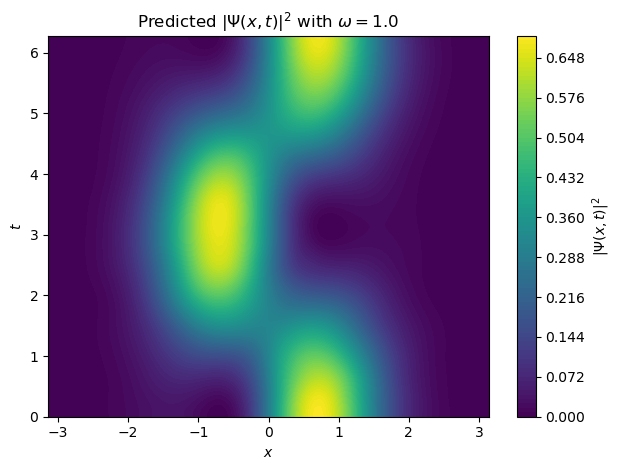

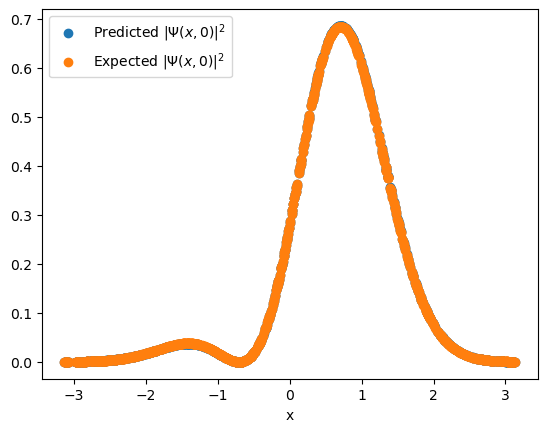

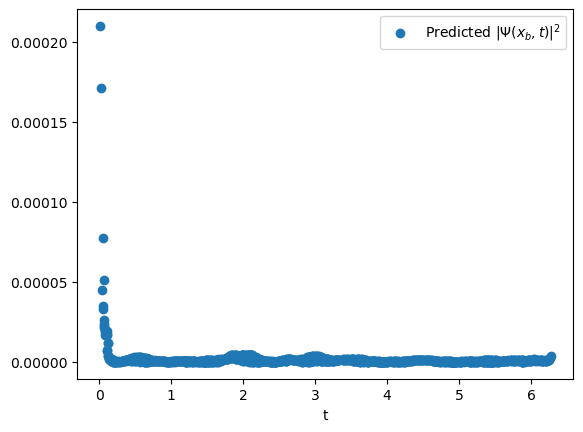

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# declare inputs
# w_min, w_max = tf.constant(0.75, dtype=DTYPE), tf.constant(2.0, dtype=DTYPE)
w_choice = tf.constant(1.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = -pi, pi
t_min, t_max = tf.constant(0.0, dtype=DTYPE), 2.0*pi

# scale inputs
@tf.function
def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# # renormalization
# @tf.function
# def normalization(input_min, input_max, N, psi_Re, psi_Im):
#     dx = (input_max - input_min) / tf.cast(N, dtype=DTYPE)
#     norm = tf.math.sqrt(tf.reduce_sum(psi_Re**2 + psi_Im**2) * dx)
#     return (psi_Re/norm), (psi_Im/norm)

# initial condition
@tf.function
def psi_init(x, w, pi):
    u_0 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2)
    u_1 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2) * x * tf.math.sqrt(2.0*w)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i, N_grid = 5000, 1000, 1000, 200

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
x_fs = scale_inputs(x_f, x_min, x_max)  # scaled
t_fs = scale_inputs(t_f, t_min, t_max)  # scaled

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
x_bs = scale_inputs(x_b, x_min, x_max)  # scaled
t_bs = scale_inputs(t_b, t_min, t_max)  # scaled

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)
x_is = scale_inputs(x_i, x_min, x_max)  # scaled
t_is = scale_inputs(t_i, t_min, t_max)  # scaled

psi_i = tf.cast(psi_init(x_i, w_choice, pi), tf.complex128)

# grid for normalization penalty
x_n = tf.linspace(x_min, x_max, N_grid)[:, None]
x_ns = scale_inputs(x_n, x_min, x_max)

# verify normalization
dx_i = (x_max - x_min) / N_i
norm_check = tf.reduce_sum(tf.math.abs(psi_i)**2) * dx_i
print(f'Normalization check for the initial condition: $|\Psi(x,0)|**2={norm_check}$')

# Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=2, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
# Load the model
loaded_model = tf.keras.models.load_model('best_model_w1_lbf_2.keras', custom_objects={'PINN': PINN})
print("Model loaded successfully")

loaded_model.summary()

################## Plot: Contour Plot ###############################

# Contour Plot
N = 100
x_plot = np.linspace(x_min, x_max, N)[:,None]
t_plot = np.linspace(t_min, t_max, N)[:,None]
x_plot_scaled = scale_inputs(x_plot, x_min, x_max)
t_plot_scaled = scale_inputs(t_plot, t_min, t_max)
X_grid, T_grid = np.meshgrid(x_plot, t_plot)  # t and x grid

x_plot_in = tf.convert_to_tensor(x_plot_scaled, dtype=DTYPE)
t_plot_in = tf.convert_to_tensor(t_plot_scaled, dtype=DTYPE)

density_interior = []

count = 0
for t_val in tf.unstack(t_plot_in, axis=0):
    t_in = tf.ones_like(x_plot_in) * t_val
    input = tf.concat([x_plot_in, t_in], axis=1)
    uv = loaded_model(input)
    u, v = uv[:, 0], uv[:, 1]
    density = u**2 + v**2
    # psi_Re, psi_Im = normalization(x_min, x_max, N, u, v)
    # density = psi_Re**2 + psi_Im**2
    density_interior.append(density)

# plt.figure(figsize=(8, 5))
contour = plt.contourf(X_grid, T_grid, density_interior, levels=100, cmap="viridis")
plt.colorbar(contour, label=r'$|\Psi(x,t)|^2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(f'Predicted $|\Psi(x,t)|^2$ with $\omega={w_choice}$')
plt.tight_layout()
plt.show()

################## Plot: Initial Condition ###############################

X = tf.concat([x_is, t_is], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
# psi_Re, psi_Im = normalization(x_min, x_max, N_i, u, v)
# density_initial = psi_Re**2 + psi_Im**2

plt.scatter(x_i, u**2 + v**2, label=r'Predicted $|\Psi(x,0)|^2$')
# plt.scatter(x_i, density_initial, label=r'Normalized Predicted $|\Psi(x,0)|^2$')
plt.scatter(x_i, tf.math.abs(psi_i)**2, label=r'Expected $|\Psi(x,0)|^2$')
plt.xlabel('x')
plt.legend()
plt.show()

################## Plot: Boundary Condition ###############################

X = tf.concat([x_bs, t_bs], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
# psi_Re, psi_Im = normalization(x_min, x_max, N_b, u, v)
# density_boundary = psi_Re**2 + psi_Im**2

plt.scatter(t_b, u**2 + v**2, label=r'Predicted $|\Psi(x_b,t)|^2$')
# plt.scatter(t_b, density_boundary, label=r'Normalized Predicted $|\Psi(x_b,t)|^2$')
plt.xlabel('t')
plt.legend()
plt.show()

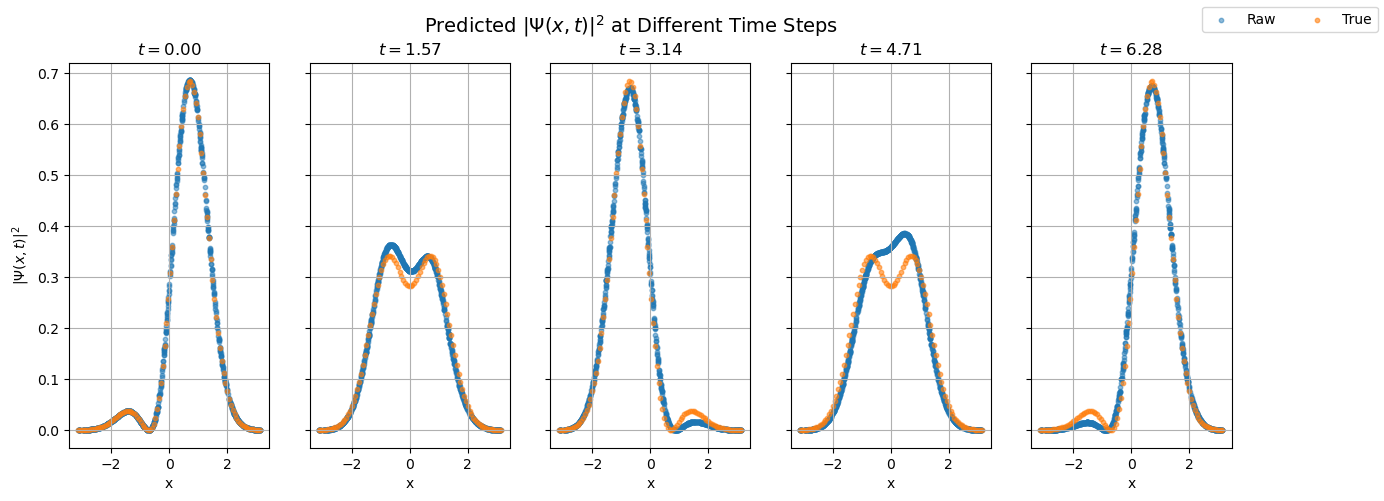

In [14]:
x_true = np.linspace(x_min, x_max, 100)

# Compute theoretical |Psi(x,t)|^2 as before
def U_0(x, t):
    w = 1.0
    return np.exp(-1j * 0.5 * w * t) * (w/np.pi)**0.25 * np.exp(-w * x**2 / 2.0)

def U_1(x, t):
    w = 1.0
    return np.exp(-1j * 1.5 * w * t) * (w/np.pi)**0.25 * np.exp(-w * x**2 / 2.0) * x * np.sqrt(2.0*w)

# Define time steps
t_test = [0, np.pi/2.0, np.pi, 1.5*np.pi, 2.0*np.pi]

# Create subplots
fig, axs = plt.subplots(1, len(t_test), figsize=(15, 5), sharey=True)

for i, t_val in enumerate(t_test):
    t_in = tf.ones_like(x_is) * t_val
    t_ins = scale_inputs(t_in, t_min, t_max)
    X = tf.concat([x_is, t_ins], axis=1)
    uv = loaded_model(X)
    u, v = uv[:, 0:1], uv[:, 1:2]
    # psi_Re, psi_Im = normalization(x_min, x_max, N_b, u, v)
    # density = psi_Re**2 + psi_Im**2

    t_true = np.ones_like(x_true) * t_val
    psi_true = (1.0 / np.sqrt(2.0)) * (U_0(x_true, t_true) + U_1(x_true, t_true))
    density_true = np.abs(psi_true)**2

    ax = axs[i]
    # ax.scatter(x_i, density, s=10, label="Normalized", alpha=0.7)
    ax.scatter(x_i, u**2 + v**2, s=10, label="Raw", alpha=0.5)
    ax.scatter(x_true, density_true, s=10, label="True", alpha=0.6)
    ax.set_title(f"$t = {t_val:.2f}$")
    ax.set_xlabel("x")
    if i == 0:
        ax.set_ylabel(r"$|\Psi(x,t)|^2$")
    ax.grid(True)

# Add a single legend and adjust layout
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=2)
fig.suptitle("Predicted $|\Psi(x,t)|^2$ at Different Time Steps", fontsize=14)
# plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()